Correlation Air Quality, Traffic, and Weather Data in Melbourne (May 2024)

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.linear_model import LinearRegression
import numpy as np

from air_quality import fetch_air_quality_data
from weather_station import fetch_weather_station_data

Visualisations for Air Quality Data in Melboune (May 2024)

In [2]:
df_air_quality_data = fetch_air_quality_data()      # Fetch air quality data

Bar Chart Visualisation of PM2.5 Levels for Melbourne Air Quality Stations

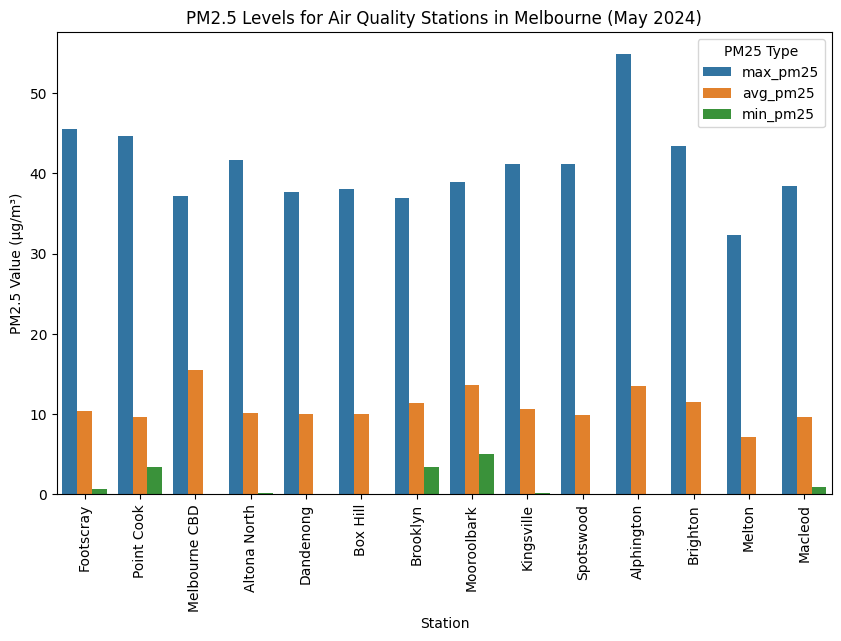

In [3]:
# Bar Chart Visualization
df_bar_chart = df_air_quality_data[['station_name', 'max_pm25', 'avg_pm25', 'min_pm25']]
df_bar_chart_melted = df_bar_chart.melt(id_vars=['station_name'], var_name='PM25 Type', value_name='PM25 Value')

plt.figure(figsize=(10, 6))
sns.barplot(x='station_name', y='PM25 Value', hue='PM25 Type', data=df_bar_chart_melted)
plt.title('PM2.5 Levels for Air Quality Stations in Melbourne (May 2024)')
plt.xlabel('Station')
plt.ylabel('PM2.5 Value (µg/m³)')
plt.xticks(rotation=90)
plt.show()

Map of Air Quality Stations Locations in Melbourne

In [4]:
# Define the map center
map_center = [df_air_quality_data['latitude'].mean(), df_air_quality_data['longitude'].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=10)

# Add marker cluster to the map
marker_cluster = MarkerCluster().add_to(air_quality_map)

# Add markers for each station
for idx, row in df_air_quality_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['station_name']} (PM2.5: {row['avg_pm25']:.2f} µg/m³)",
        tooltip=row['station_name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Save the map to an HTML file
air_quality_map.save('melbourne_air_quality_map.html')

# Display the map
air_quality_map

Visualisations for Weather Data in Melbourne (May 2024)

In [5]:
df_stations_data = fetch_weather_station_data()     # Fetch weather data

c:\Users\brian\Documents\UniMelb\Year 1\Semester 1\COMP90024 Cluster and Cloud Computing\Assignments\COMP90024 Assignment 2\Jupyter\weather_station.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stations_data = pd.concat(station_data_list, ignore_index=True)


Wind Speed Distribution for Melbourne Weather Stations

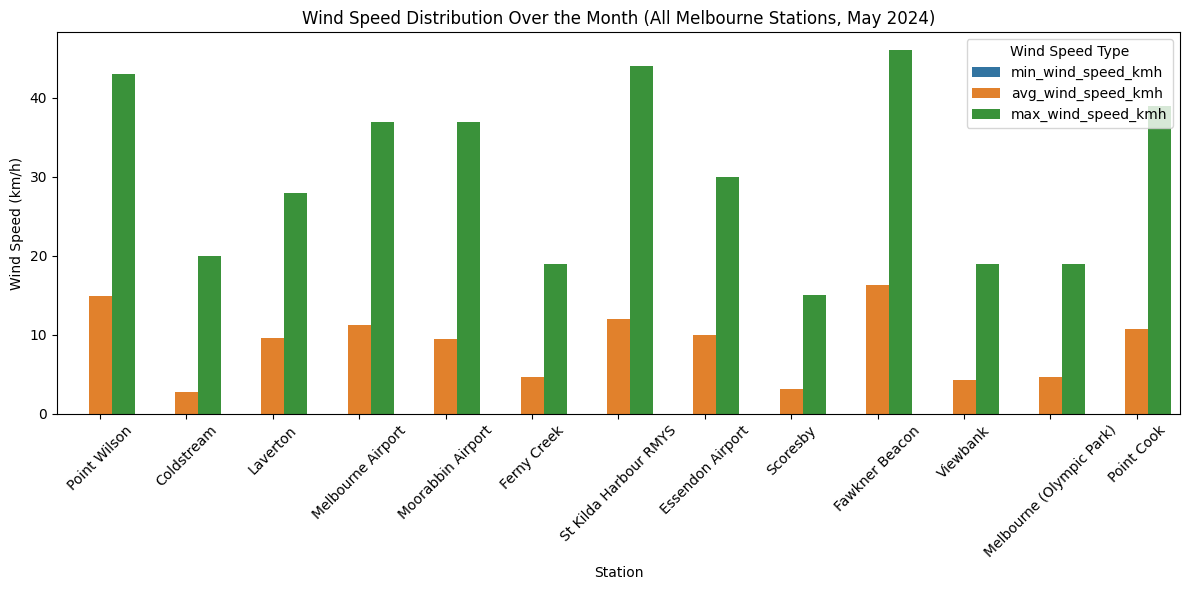

In [6]:
df_wind_speed = df_stations_data[['date_filter', 'name', 'min_wind_speed_kmh', 'avg_wind_speed_kmh', 'max_wind_speed_kmh']].copy()
df_wind_speed = df_wind_speed.melt(id_vars=['date_filter', 'name'], var_name='Wind Speed Type', value_name='Wind Speed (km/h)')

plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='Wind Speed (km/h)', hue='Wind Speed Type', data=df_wind_speed)
plt.title('Wind Speed Distribution Over the Month (All Melbourne Stations, May 2024)')
plt.xlabel('Station')
plt.ylabel('Wind Speed (km/h)')
plt.xticks(rotation=45)
plt.legend(title='Wind Speed Type')
plt.tight_layout()
plt.show()

Map of Weather Station Locations in Melbourne

In [7]:
map_center = [df_stations_data['lat'].mean(), df_stations_data['lon'].mean()]
weather_map = folium.Map(location=map_center, zoom_start=10)

marker_cluster = MarkerCluster().add_to(weather_map)

for idx, row in df_stations_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['name']} (WMO: {row['station_id']})",
        tooltip=row['name'],
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(marker_cluster)

weather_map.save('melbourne_weather_map.html')
weather_map

Visualisations for Traffic Data in Melbourne (May 2024)

In [12]:
response_traffic = requests.get("http://localhost:9090/traffic-freeway")
freeways_json = response_traffic.json()

freeways = []

for entry in freeways_json["freeways"]:
    freeways.append(entry["key"])

aggregated_data = {}

for freeway in freeways:
    freeway_data = requests.get(f"http://localhost:9090/traffic-freeway/{freeway}?year=2024&month=5").json()
    aggregated_data[freeway] = freeway_data

# Convert the aggregated data into a DataFrame
df_aggregated_data = pd.DataFrame(aggregated_data)


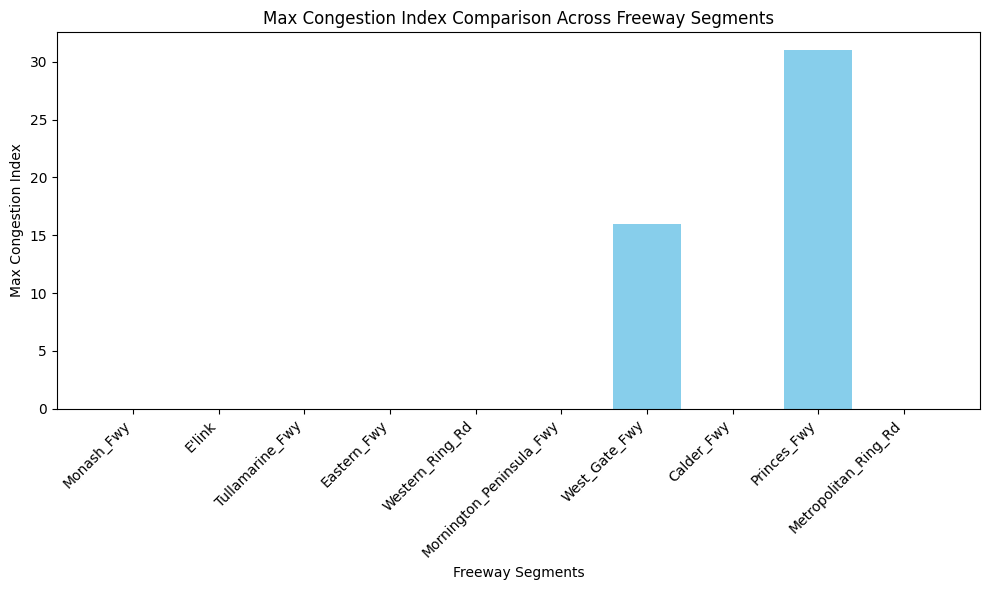

In [13]:
# Extract data for plotting
segments = list(aggregated_data.keys())
congestion_indices = [aggregated_data[segment]['max_congestion_index'] for segment in segments]

# Plotting Congestion Index Comparison
plt.figure(figsize=(10, 6))
plt.bar(segments, congestion_indices, color='skyblue')
plt.xlabel('Freeway Segments')
plt.ylabel('Max Congestion Index')
plt.title('Max Congestion Index Comparison Across Freeway Segments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

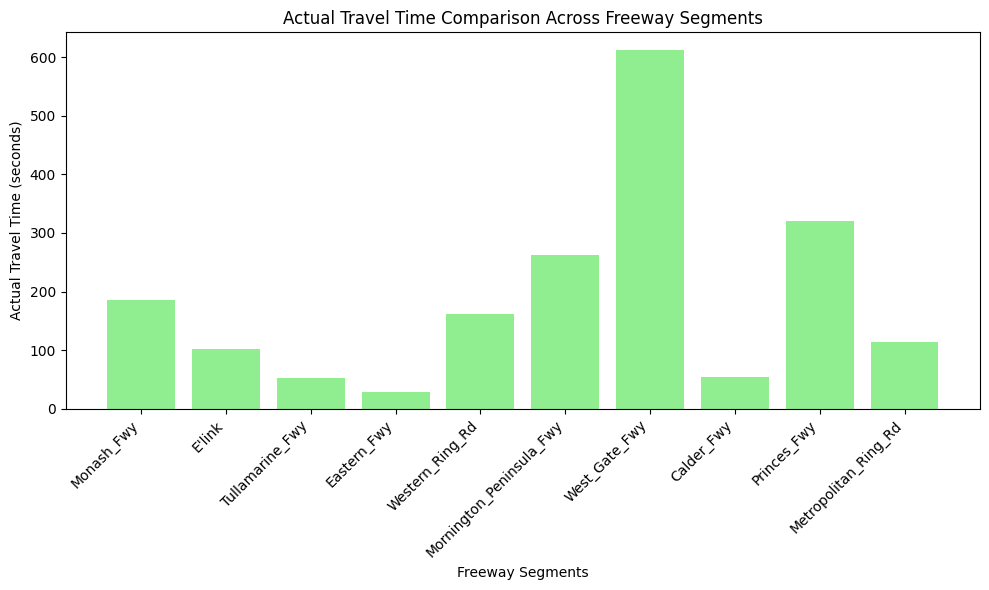

In [14]:
# Extract data for plotting
travel_times = [aggregated_data[segment]['actual_travel_time'] for segment in segments]

# Plotting Travel Time Comparison
plt.figure(figsize=(10, 6))
plt.bar(segments, travel_times, color='lightgreen')
plt.xlabel('Freeway Segments')
plt.ylabel('Actual Travel Time (seconds)')
plt.title('Actual Travel Time Comparison Across Freeway Segments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


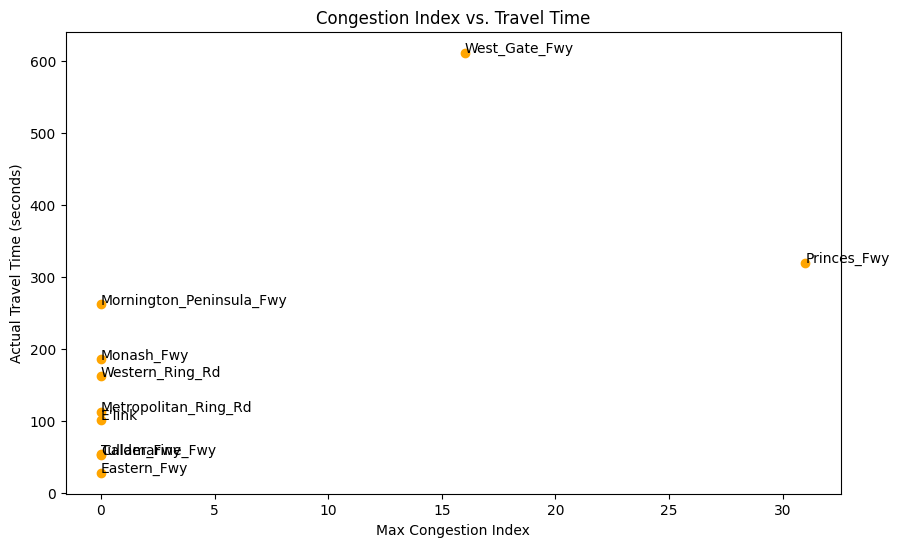

In [15]:
# Plotting Congestion Index vs. Travel Time
plt.figure(figsize=(10, 6))
plt.scatter(congestion_indices, travel_times, color='orange')
for i, txt in enumerate(segments):
    plt.annotate(txt, (congestion_indices[i], travel_times[i]))
plt.xlabel('Max Congestion Index')
plt.ylabel('Actual Travel Time (seconds)')
plt.title('Congestion Index vs. Travel Time')
plt.show()

Map of Freeway Locations in Melbourne

In [26]:
df_traffic = pd.read_csv('../data/final_combined_df.csv')

# Initialize a list to hold the extracted coordinates
extracted_coords = []

# Iterate through each row in the DataFrame to extract the first coordinate from 'geometry'
for idx, row in df_traffic.iterrows():
    if pd.notna(row['geometry']) and row['geometry'].strip():
        try:
            # Extract the coordinates from the 'geometry' column
            coordinates_str = row['geometry'].replace('LINESTRING (', '').replace(')', '')
            coordinates_list = coordinates_str.split(', ')
            first_coord = coordinates_list[0]
            lon, lat = map(float, first_coord.split())
            extracted_coords.append({
                'road': row['Segment'],
                'segment_name': row['segment_name'],
                'lat': lat,
                'lon': lon
            })
        except (ValueError, IndexError) as e:
            pass

# Convert the extracted coordinates to a DataFrame
df_extracted_coords = pd.DataFrame(extracted_coords)

# Initialize a Folium map
map_center = [-37.8136, 144.9631]  # Center the map around Melbourne
traffic_map = folium.Map(location=map_center, zoom_start=10)

# Add marker cluster to the map
marker_cluster = MarkerCluster().add_to(traffic_map)

# Track if markers are added
markers_added = False

# Iterate through the extracted coordinates DataFrame and add markers
for idx, row in df_extracted_coords.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['road']} (Segment Name: {row['segment_name']})",
        tooltip=row['road'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)
    markers_added = True

if markers_added:
    # Save the map to an HTML file
    traffic_map.save('melbourne_traffic_map.html')
else:
    print("No markers were added to the map.")

# Display the map
traffic_map

Combined Dataset Visualisations (May 2024)

note: 
Final_combined_df was obtained after merging all the data from the APIs and sudo dataset, to merge the dataset.
Please run join_data.py script in the frontend folder.

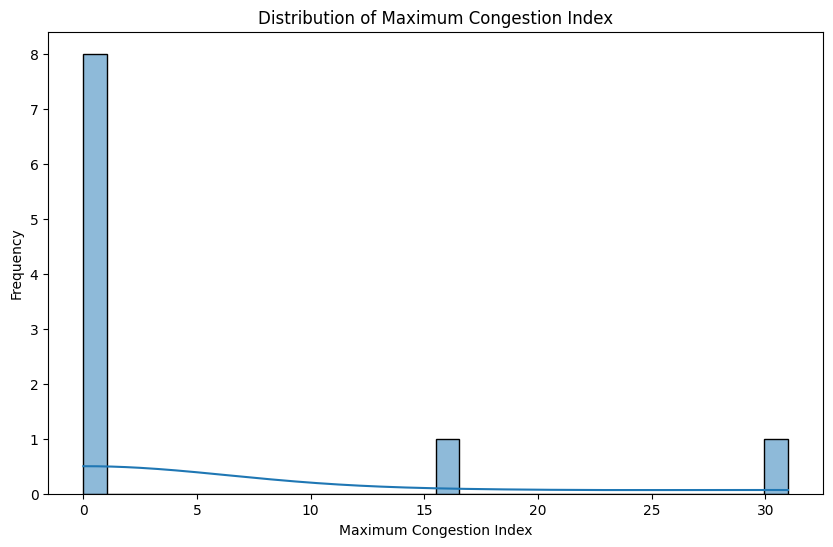

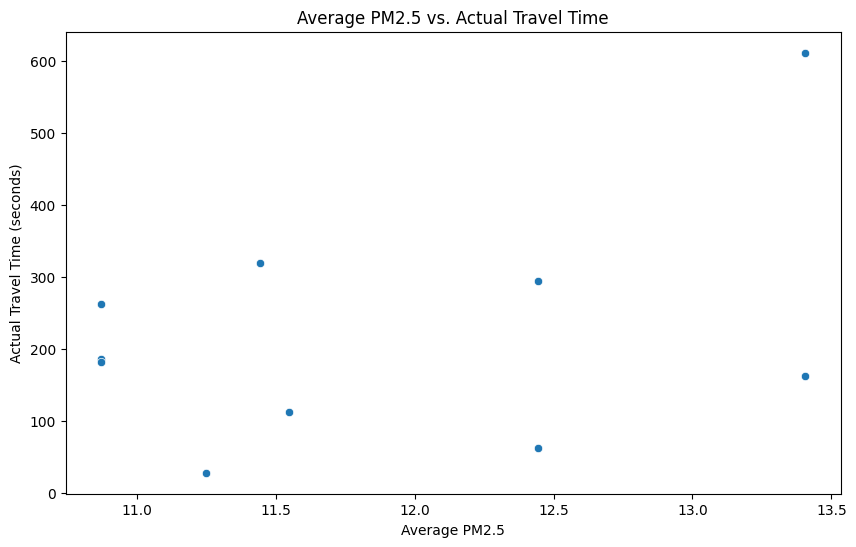

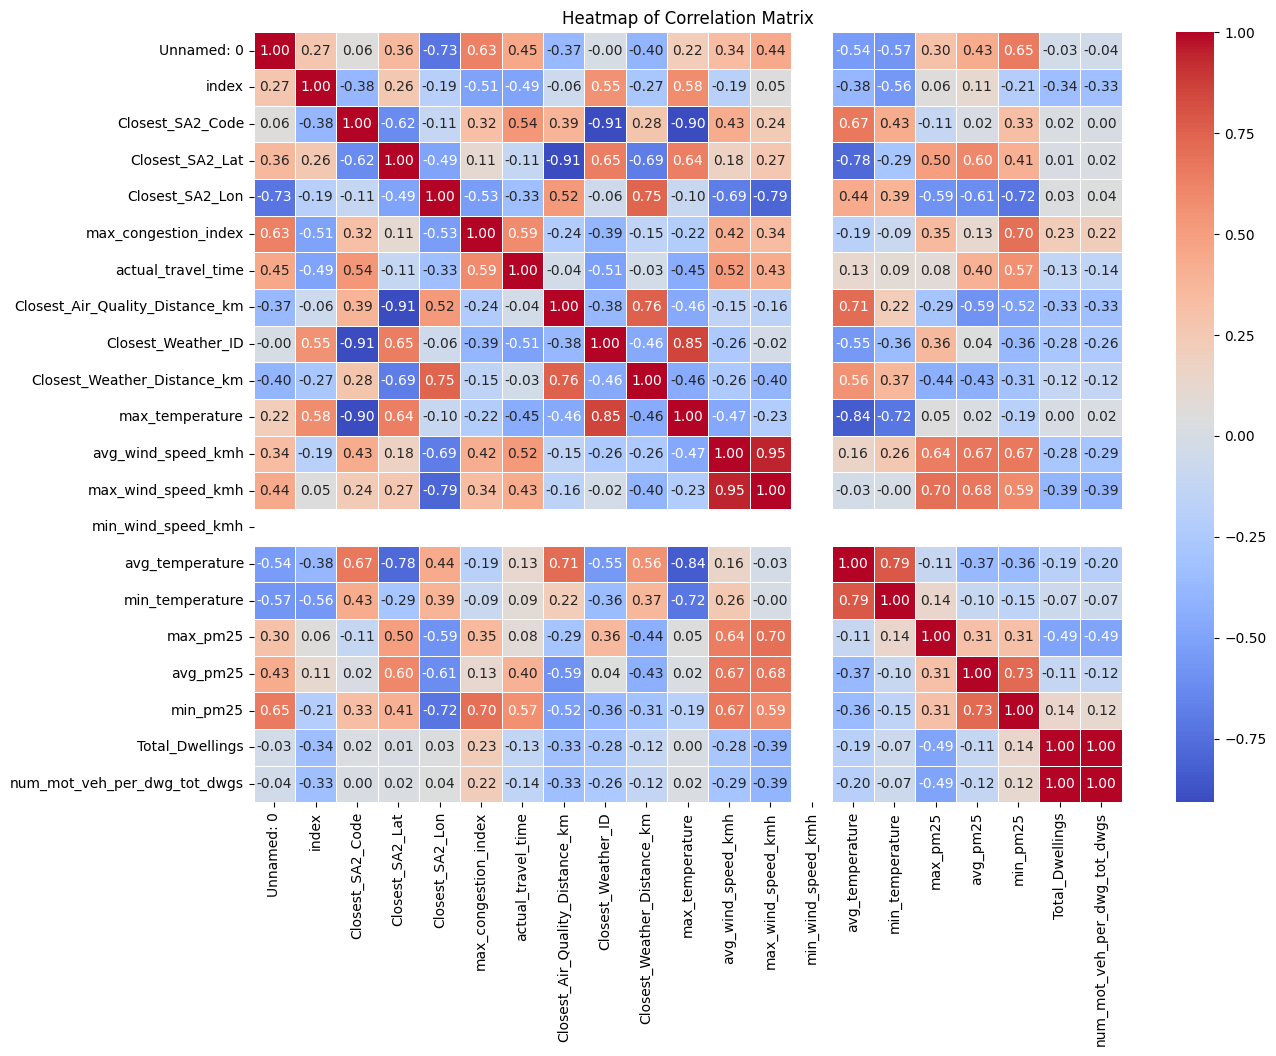

In [27]:
df = pd.read_csv("../data/final_combined_df.csv")

# Distribution of Maximum Congestion Index
plt.figure(figsize=(10, 6))
sns.histplot(df['max_congestion_index'], bins=30, kde=True)
plt.title('Distribution of Maximum Congestion Index')
plt.xlabel('Maximum Congestion Index')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Average PM2.5 vs. Actual Travel Time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_pm25', y='actual_travel_time')
plt.title('Average PM2.5 vs. Actual Travel Time')
plt.xlabel('Average PM2.5')
plt.ylabel('Actual Travel Time (seconds)')
plt.show()

# Heatmap of Correlation Matrix
numeric_cols = df.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

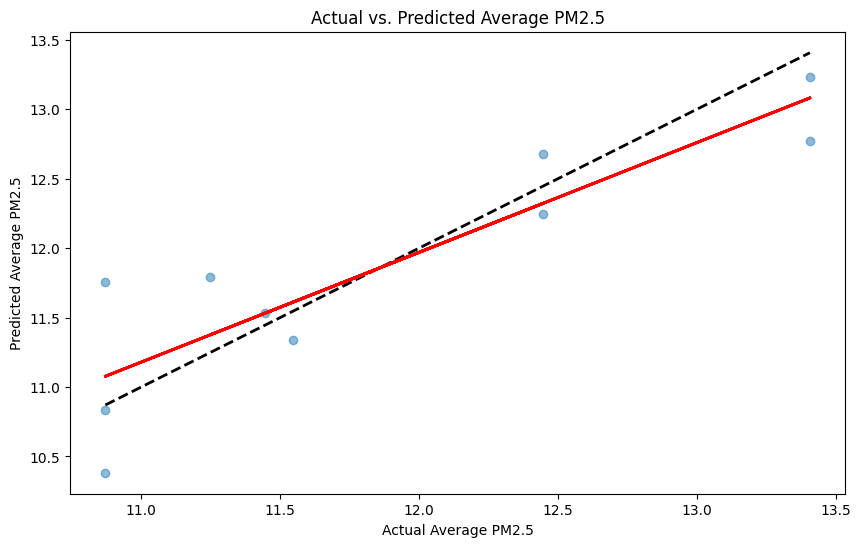

In [28]:
# Ensure the columns are correctly named and strip any extra spaces
df.columns = df.columns.str.strip()

# Select features and target
features = ['max_congestion_index', 'actual_travel_time', 'max_wind_speed_kmh', 'avg_temperature', 'num_mot_veh_per_dwg_tot_dwgs']
target = 'avg_pm25'

# Drop rows with missing values for simplicity
df = df.dropna(subset=features + [target])

# Define the features (X) and target (y)
X = df[features]
y = df[target]

# Train the model on the entire dataset
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plot actual vs. predicted PM2.5 levels
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Average PM2.5')
plt.ylabel('Predicted Average PM2.5')
plt.title('Actual vs. Predicted Average PM2.5')

# Add a linear fit line
slope, intercept = np.polyfit(y, y_pred, 1)
plt.plot(y, slope * y + intercept, color='red', linewidth=2)

plt.show()

Combined Map of the Location of Air Quality Stations, Weather Stations and Highways in Melbourne

In [25]:
# Initialize a list to hold the extracted coordinates for traffic data
extracted_coords = []

# Extract the first coordinate from 'geometry' for traffic data
for idx, row in df_traffic.iterrows():
    if pd.notna(row['geometry']) and row['geometry'].strip():
        try:
            # Extract the coordinates from the 'geometry' column
            coordinates_str = row['geometry'].replace('LINESTRING (', '').replace(')', '')
            coordinates_list = coordinates_str.split(', ')
            first_coord = coordinates_list[0]
            lon, lat = map(float, first_coord.split())
            extracted_coords.append({
                'road': row['Segment'],
                'segment_name': row['segment_name'],
                'lat': lat,
                'lon': lon
            })
        except (ValueError, IndexError) as e:
            pass

# Convert the extracted coordinates to a DataFrame
df_extracted_coords = pd.DataFrame(extracted_coords)

# Define the map center based on air quality data
map_center = [df_air_quality_data['latitude'].mean(), df_air_quality_data['longitude'].mean()]
combined_map = folium.Map(location=map_center, zoom_start=10)

# Add marker cluster to the map
marker_cluster = MarkerCluster().add_to(combined_map)

# Add markers for air quality stations
for idx, row in df_air_quality_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['station_name']} (PM2.5: {row['avg_pm25']:.2f} µg/m³)",
        tooltip=row['station_name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Add markers for weather stations
for idx, row in df_stations_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['name']} (WMO: {row['station_id']})",
        tooltip=row['name'],
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(marker_cluster)

# Add markers for traffic data
for idx, row in df_extracted_coords.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['road']} (Segment Name: {row['segment_name']})",
        tooltip=row['road'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)

# Save the map to an HTML file
combined_map.save('melbourne_combined_map.html')

# Display the map
combined_map